<a href="https://colab.research.google.com/github/sivantrajtenberg/Quantum-Secure-Deep-Learning/blob/main/QSDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# QSDL Digital twin
Enhance machine learning useing an optical system. The system is:
Based on the paper:
https://arxiv.org/pdf/2408.05629v2


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
colors = ["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00",'#CC79A7', 'darkmagenta','cadetblue','blueviolet','darkred','k']
matplotlib.rcParams.update({'font.size': 20})
import cupy as cp

In [12]:
###################################
## Helper functions for the vectors
###################################
def make_logi_info(x_logi, w_logi):
  if len(x_logi) % 2 != 0 or len(x_logi) % 2 != 0:
      raise ValueError("Input arrays must have an even number of elements.")
  x_info = cp.zeros(int(len(x_logi)/2)) + 1j*0
  w_info = cp.zeros(int(len(w_logi)/2)) + 1j*0
  for i in range(len(x_info)):
    w_info[i] = w_logi[2*i] + 1j*w_logi[2*i+1]
    x_info[i] = x_logi[2*i] - 1j*x_logi[2*i+1]
  return x_info,w_info


def make_two_vec_gauss1(x_info,w_info,t,sigma,bin_time):
    w = cp.zeros(len(t)) + 1j*0
    x = cp.zeros(len(t)) + 1j*0
    bin_size = (len(t)-1)/ np.round(t[-2] / t_time_bin)
    for i in range(len(x_info)):
        cen = (i+0.5) * t_time_bin
        t_temp = t[i*bin_size:(i+1)*bin_size - 1]
        w[i*bin_size:(i+1)*bin_size - 1] = w_info[i] * np.exp(-(t_temp - cen)**2 / (2 * sigma**2))# * 1/(sigma * np.sqrt(2 * np.pi))
        x[i*bin_size:(i+1)*bin_size - 1] = x_info[i] * np.exp(-(t_temp  - cen)**2 / (2 * sigma**2))# * 1/(sigma * np.sqrt(2 * np.pi))
        #w = w + w_info[i] * np.exp(-(t - cen)**2 / (2 * sigma**2))# * 1/(sigma * np.sqrt(2 * np.pi))
        #x = x + x_info[i] * np.exp(-(t - cen)**2 / (2 * sigma**2))# * 1/(sigma * np.sqrt(2 * np.pi))
    return x,w

###################################
## Helper functions for the filter
###################################
def Fourier(x):
    N = len(x)
    return cp.fft.fftshift(cp.fft.fft(x)) / cp.sqrt(N)

def iFourier(x):
    N = len(x)
    return cp.fft.ifft(cp.fft.ifftshift(x)) * np.sqrt(N)

def apply_filter(u,filt):
    ufft = Fourier(u)
    ufft = ufft * filt
    u = iFourier(ufft)
    return u

def lorentzian( x, x0, a, gam ):
    return a * gam**2 / ( gam**2 + ( x - x0 )**2)

def lorentzianT( x, x0, a, gam ):
    return a / (1 + 1j*( x - x0 )/gam)

def lorentzianR( x, x0, a, gam ): ##THIS MIGHT BE AN ERROR CHECK!!!!
    return cp.sqrt(1 - cp.abs(lorentzianT( x, x0, a, gam ))**2)

BS = cp.array([[1, 1], [1, -1]]) / cp.sqrt(2)

def energy(u):
    return np.sum(np.abs(u)**2)

############################################
## Helper functions for the Information leakage
############################################

def g(nu):
    return ( (nu + 1) / 2 ) * cp.log2( (nu + 1) / 2 ) - ( (nu - 1) / 2 ) * cp.log2( (nu - 1) / 2 )

def calculate_S_AB(alpha, T, xi):
    V = 2*alpha**2 + 1 #Check!
    a = V
    b = T * (V - 1) + 1 + xi
    c = cp.sqrt(T * (V**2 - 1))
    z = cp.sqrt((a + b)**2 - 4 * c**2)

    nu1 = 0.5 * (z + b - a)
    nu2 = 0.5 * (z - b + a)

    S_AB = g(nu1) + g(nu2)
    return float(S_AB)

## First part: preparation
In this part we prepare the logical vectors, the actual vectors, and run thorugh the phase shifter and BS. For the deep learning computation, we have:

**Logical** $x_{logi}$ (**real**): continuous real positive values between 0 and 1.  
**Logical** $w_{logi}$ (**real**): continuous real values with average of 0 and variance of 1.  
From these we calcualte:
**Complex** $x/w$:  
$$ w^c_i = w_{logi,2i} + i w_{logi,2i+1}, \quad x^c_i = x_{logi,2i} - i x_{logi,2i+1} $$  

Where the imporatant part of this computation is that:
$$ \text{RE}[w^c \cdot x^c] = \text{RE}[w_{logi} \cdot x_{logi}] $$


We define:

  - $x_{logi}$,$w_{logi}$ : the real logical vectors, of length N. This is double the size of the ACTUAL vectors, as this is the real vector size.
  - 𝑤,x the physical vectors, comprised of time bins with gaussian pulses
  - $\tau$ - the duration of the Gaussian pulse
  - t_time_bin - the seperation between Gaussian Pulses
  - t_end_justdata - the time of information incoding / or N the number of pulses
  - $\alpha = \sqrt{\mu}$ the population of photons per pulse

Default parameters:
20 ps-long Gaussian pulses spaced by 200 ps, N = 50

**Some imporant points regarding normalizations**:
1. The $\vec{x}$ vector must be normalized so that $sin^-1(|x|)$ is real. We do this by determinig $x' = x/\sqrt(2)$ and normalizing the final product by $\sqrt(2)$.
2. In order to have small amplitudes (quantum light), we normalize $\vec{w}$ so that the average intensity is 1 by dividing by the mean intensity, and then multiple by the population $\alpha$. We have to keep the value of the mean intesnity to normalize the final output.
3. When working with gaussian pulses we basically are oversampling by the area of the pulse, so we have to normalize against that as well. The area of a single pulse is given nalaytically by: $\frac{\tau \ sqrt(\pi)}{tstep}$

The final output should therefoe be:
$$\vec{w_{logi}} \cdot \vec{x_{logi}} = \frac{\vec{w} \cdot \vec{x}}{\sqrt(2) \alpha \frac{|\vec{w}|^2}{N} \frac{\tau \ sqrt(\pi)}{tstep})}$$

Confirm that the intter product is conserved
---------------------------------------------
Ground truth is 5.375641
With complex vectors is 5.375641
With pulsed waveforms is 5.375641


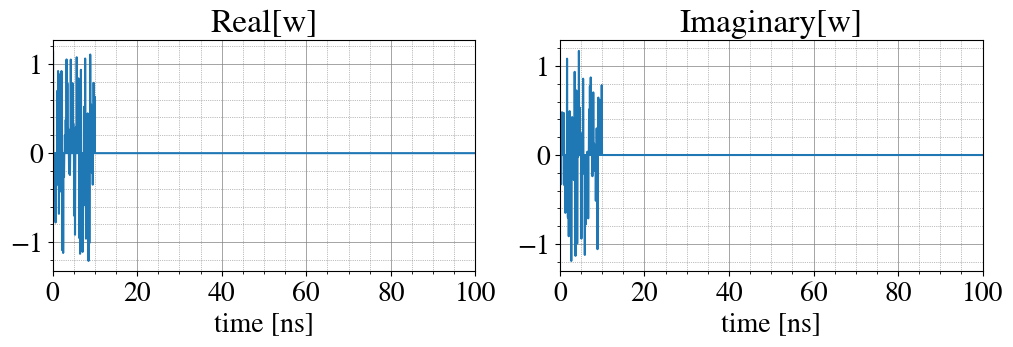

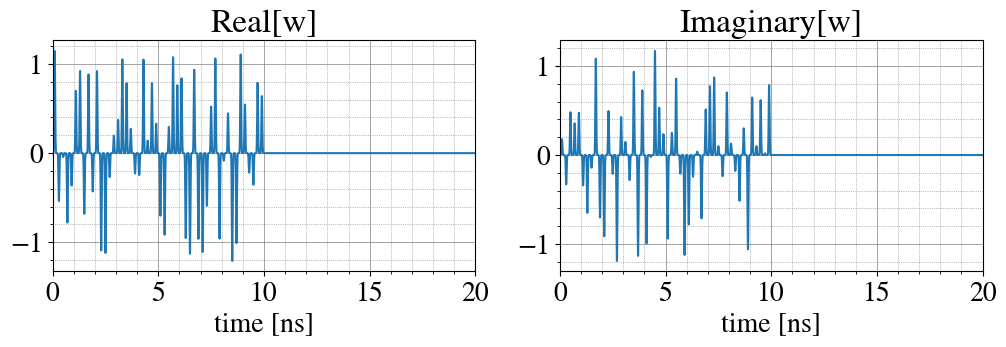

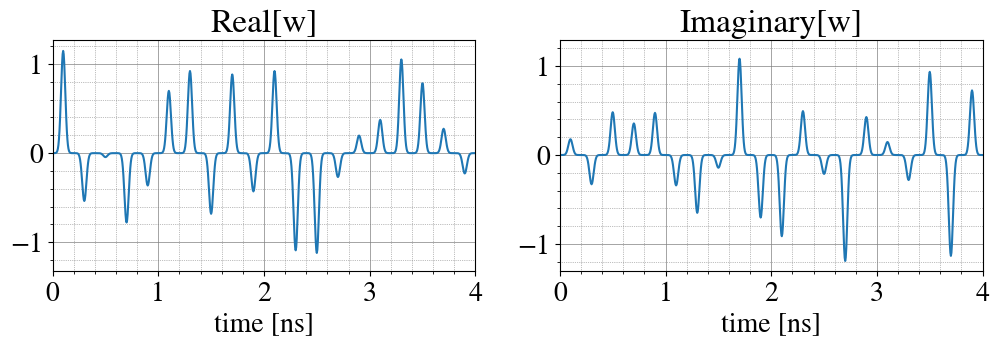

In [15]:
#################################
# Define the size for the vectors
#################################
N = 100                         # Number of logical sizes
tau = 20e-12;                # Gaussian width (std. dev.)
tend = 100e-9                  # last time of the vector
t_time_bin = 200e-12           # sepeation between pulses

####### time domain
tend_justdata = N * t_time_bin #end of information
# N = int(tend_justdata /t_time_bin )
tstep = tau / 4 #size of time step
tstart = 0
t = cp.arange(tstart, tend, tstep)
Ntotal = len(t)

####### frequeny domain
fstart = -1/(2*tstep); fend = 1/(2*tstep); fstep = 1/(Ntotal*tstep)
f = cp.linspace(fstart, fend, len(t))

#################################
# Create the com logical real vectors x,w
#################################
x_logi = np.random.uniform(-1, 1, N)
w_logi = np.random.uniform(-1, 1, N)

#################################
# Create the complex vectors x,w
#################################
x_info, w_info = make_logi_info(x_logi, w_logi)

w,x = make_two_vec_gauss1(w_info,x_info,t,tau,t_time_bin)
x = x / np.sqrt(2) # normalize to possible to take sin^-1

factor_w = np.sqrt(np.mean(np.abs(w_info)**2))  # normalize the average intensity
alpha = 1
w = alpha * w / factor_w # normalize so that the mean of the power is 1

################################
# Plot
################################

for xlim_last in [tend*1e9,tend_justdata*1e9,0.2*tend_justdata*1e9]:
  fig,ax = plt.subplots(1,2, figsize =(12,3))
  plt.title('Input wave')
  ax[0].plot(cp.asnumpy(t*1e9),np.real(cp.asnumpy(w)))
  ax[0].set_title('Real[w]')
  ax[1].plot(cp.asnumpy(t*1e9),np.imag(cp.asnumpy(w)))
  ax[1].set_title('Imaginary[w]')
  for a in ax:
      a.set_xlim([0,xlim_last])
      a.set_xlabel('time [ns]')
      a.minorticks_on()
      a.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
      a.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

print('Confirm that the intter product is conserved')
print('---------------------------------------------')
ground_truth = np.real(np.sum(cp.asnumpy(x_logi) *cp.asnumpy(w_logi)))
print('Ground truth is %f'%ground_truth)
complex_vectors = np.real(np.sum(cp.asnumpy(x_info) *cp.asnumpy(w_info)))
print('With complex vectors is %f'%ground_truth)
normalization = factor_w / (tau / tstep * np.sqrt(np.pi)) * np.sqrt(2)  / alpha
real_vector = np.real(np.sum(x * w)) * normalization
print('With pulsed waveforms is %f'%real_vector)

In [7]:
def step_1(x,w):

    #Add the phase
    PS = cp.vstack((cp.exp(1j * (cp.arcsin(cp.abs(x))+cp.angle(x))), cp.exp(-1j * (cp.arcsin(cp.abs(x))-cp.angle(x)))))

    #make a vector of the amplitudes in one arm, and zeroes on the second arm
    f0 = cp.vstack((w, cp.zeros(len(w))))

    #Go: BS, then phase shifter on one arm, then BS again
    f1 = BS @ (PS * (BS @ f0))
    u = f1[1,:]
    u_tag = f1[0,:]

    return u, u_tag

u, u_tag = step_1(x,w)

#Confirm that the intter product is conserved
print('Ground truth is %f'%ground_truth)
after_BS = np.imag(np.sum(cp.asnumpy(u)))* normalization#This factor is because we normalize x!!!
print('After BS is %f'%after_BS)

Ground truth is -4.332940
After BS is -4.332940


## Second part: Filter and detection
### Filter
In this part we pass through the filter.
We define:

1. $\gamma$ - the width of the (Lorenzian) filter. Notice that the lorenzian is calculated in the amplitude (not intesnity) so this value has to be divided by 2 for calculation of the filter.

Energy conservation check: the input is 87.088080
Real: the filtered is 0.709564 and the reflected is 86.378516, their sum is 87.088080


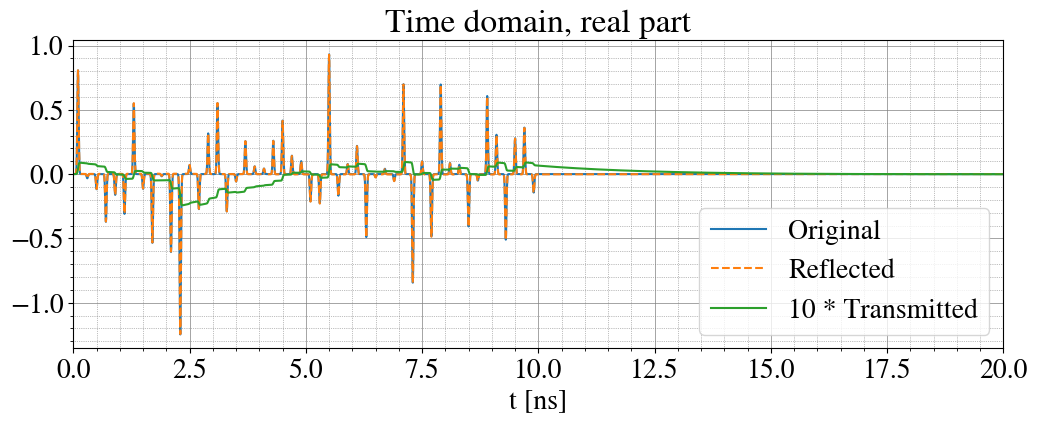

In [8]:
def step_2(u,gam,f):
    x0 = 0

    #Go through the filter
    ufft = Fourier(u)
    filtered_ufft = lorentzianT( f, x0, 1, gam )*ufft
    reflected_ufft = lorentzianR( f, x0, 1, gam )*ufft

    filtered_u = iFourier(filtered_ufft)
    reflected_u = iFourier(reflected_ufft)

    return filtered_u, reflected_u

gam = 100e6;
filtered_u, reflected_u = step_2(u,gam/2,f)

#Check energy conservation
print('Energy conservation check: the input is %f'%energy(u))
print('Real: the filtered is %f and the reflected is %f, their sum is %f'%(energy(filtered_u),energy(reflected_u),energy(filtered_u)+energy(reflected_u)))

plt.figure(figsize = (12,4))
plt.plot(cp.asnumpy(t*1e9),np.real(cp.asnumpy(u)),label = 'Original')
plt.plot(cp.asnumpy(t*1e9),np.real(cp.asnumpy(reflected_u)),'--',label = 'Reflected')
plt.plot(cp.asnumpy(t*1e9),np.real(cp.asnumpy(filtered_u))*10,label = '10 * Transmitted')
plt.xlabel('t [ns]')
plt.title('Time domain, real part')
plt.grid()
plt.legend()
plt.xlim([0,20])
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

## Detection
Homodyne detection will be modeled as two detectors on a beam splitter, with a strong field incoming. We will ingore the fast oscillating phase of the LO, and set the phase of the LO such that it returns the imaginary part of the input to it.

In [9]:
def do_homodyn(filtered_u):
    #Add a phase to the LO to get the imaginary part. set to 0 for real part
    f5 = cp.vstack((filtered_u, cp.exp(1j*np.pi/2)*cp.ones(cp.shape(filtered_u))))
    f6 = BS @ f5

    #Measure the Intensity on the APDs
    I1 = cp.sum(cp.abs(f6[0,:])**2)
    I2 = cp.sum(cp.abs(f6[1,:])**2)

    return (I1-I2)/2

after_filter = np.imag(np.sum(cp.asnumpy(filtered_u)))* normalization #integrate
print('The sum og the imaginary part of the input to the detector (filtered): %f'%after_filter)
after_homodyn =  do_homodyn(filtered_u)* normalization
print('The result of teh homodyn detection measurement: %f'%after_homodyn)

The sum og the imaginary part of the input to the detector (filtered): -4.325277
The result of teh homodyn detection measurement: -4.325277


## Part 3: calculate the returning vector
In this part we run thorugh the phase shifter and BS for the return light to find the return vector $\vec{w'}$. This vector will be used to calculate T and $\xi$, which in turn will help us calculate the information leakage.

### Calculating T and $\xi$
As defind by:
$$T = \frac{|w'|^2}{|w|^2}$$
$$\xi = \frac{|w-w'|^2}{|w|^2}$$

T = 0.997656
xi = 0.000013


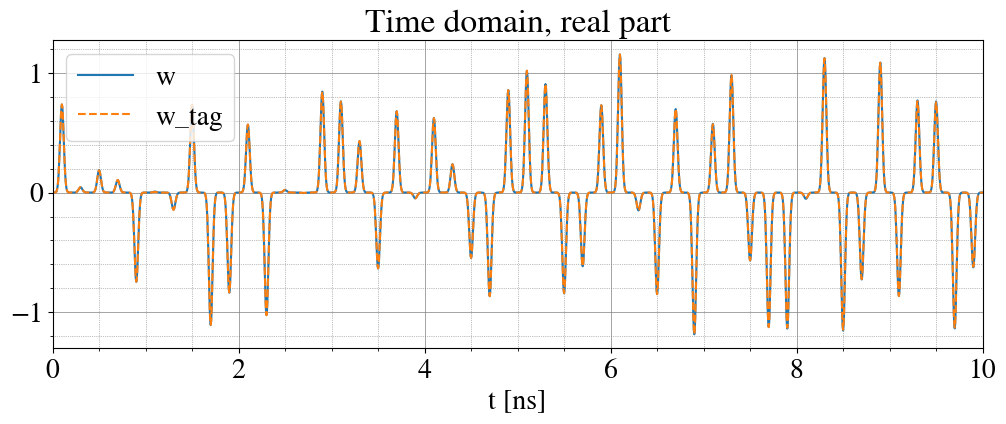

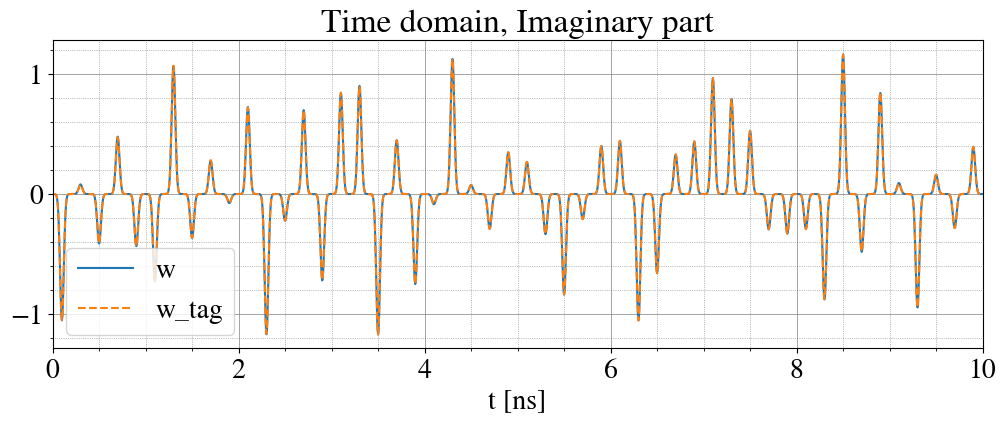

In [11]:
def step_3(x,reflected_u,u_tag):

    #Add the phase
    PS1 = cp.vstack((cp.exp(-1j * (cp.arcsin(np.abs(x))+cp.angle(x))), cp.exp(1j * (cp.arcsin(cp.abs(x))-cp.angle(x)))))

    #make a vector of the amplitudes in one arm, and the other arm of the first splitter
    f2 = cp.vstack((reflected_u, u_tag))

    #Go: BS, then phase shifter on one arm, then BS again
    f3 = BS @ (PS1 * (BS @ f2))
    w_tag = f3[1,:]

    return w_tag

w_tag = step_3(x,reflected_u,u_tag)

#Calculate the metrics
T = cp.sum(cp.abs(w_tag)**2) / cp.sum(cp.abs(w)**2)
print('T = %f'%T)

xi = cp.sum(cp.abs(w_tag-w)**2) / cp.sum(cp.abs(w)**2)
print('xi = %f'%xi)

plt.figure(figsize = (12,4))
plt.plot(cp.asnumpy(t*1e9),np.real(cp.asnumpy(w)),label = 'w')
plt.plot(cp.asnumpy(t*1e9),np.real(cp.asnumpy(w_tag)),'--',label = 'w_tag')
plt.xlabel('t [ns]')
plt.title('Time domain, real part')
plt.grid()
plt.legend()
plt.xlim([0,tend_justdata*1e9])
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

plt.figure(figsize = (12,4))
plt.plot(cp.asnumpy(t*1e9),np.imag(cp.asnumpy(w)),label = 'w')
plt.plot(cp.asnumpy(t*1e9),np.imag(cp.asnumpy(w_tag)),'--',label = 'w_tag')
plt.xlabel('t [ns]')
plt.title('Time domain, Imaginary part')
plt.grid()
plt.legend()
plt.xlim([0,tend_justdata*1e9])
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

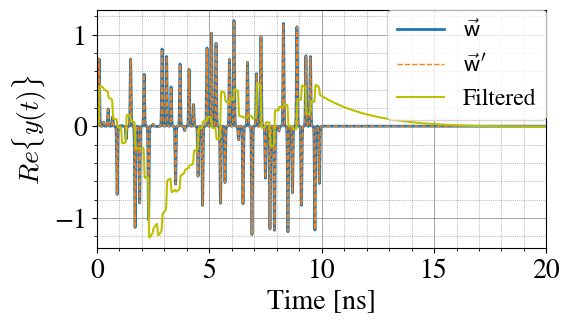

In [16]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams.update({'font.size': 20})

if 0:
  data = np.load('w_w_tag.npz')
  w = data['w']
  t = data['t']
  w_tag = data['w_tag']
  filtered_u = data['filtered_u']
  tend_justdata = data['tend_justdata']

plt.figure(figsize = (5.8,3.1))
plt.plot(cp.asnumpy(t*1e9),np.real(cp.asnumpy(w)),linewidth= 2, label = r"$\vec{\mathsf{w}}$")
plt.plot(cp.asnumpy(t*1e9),np.real(cp.asnumpy(w_tag)),'--',linewidth= 1, markersize = 2,label = r"$\vec{\mathsf{w}}'$")
plt.plot(cp.asnumpy(t*1e9),np.real(cp.asnumpy(filtered_u))*50,'y',label = 'Filtered')
plt.xlabel('Time [ns]')
plt.ylabel(r"$Re\{y(t)\}$") #FILL THIS
#plt.title('Time domain, real part')
plt.grid()
plt.legend(loc = 'upper right', fontsize = 17, bbox_to_anchor=(1.025, 1.05))
plt.xlim([0,2*tend_justdata*1e9])
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

if 0:
  plt.savefig("w_w_tag3.svg", format="svg")   # SVG format
  np.savez('w_w_tag.npz', t=t,w=w,w_tag=w_tag,tend_justdata=tend_justdata,filtered_u=filtered_u)

## Entropy Function and Calculation of the inforamtion leakage $S_{AB}$

We define the function $g(\nu)$ as:

$$
g(\nu) = \frac{\nu + 1}{2} \log_2 \left( \frac{\nu + 1}{2} \right) - \frac{\nu - 1}{2} \log_2 \left( \frac{\nu - 1}{2} \right)
$$

The function `calculate_S_AB` computes $S_{AB}$ given the parameters $\alpha$, T, and $\xi$. The key calculations are:

- Compute the variance-like quantity:
$$  V = 2\alpha^2 + 1$$
- Compute the auxiliary variables:
  $$
  a = V, \quad b = T (V - 1) + 1 + \xi, \quad c = \sqrt{T (V^2 - 1)}
  $$
- Compute the discriminant:
  $$
  z = \sqrt{(a + b)^2 - 4c^2}
  $$
- Compute the eigenvalues:
  $$
  \nu_1 = \frac{z + b - a}{2}, \quad \nu_2 = \frac{z - b + a}{2}
  $$
- Finally, compute $S_{AB}$ as:
  $$
  S_{AB} = g(\nu_1) + g(\nu_2)
  $$

  Iterate over different filter sizes as well as different encoding BWs.

with gam = 10.0 MHz, T = 0.9993980156334605 +- 0.0005577950590311101, xi = 4.218693238864322e-06 +- 4.615335706985491e-06
with gam = 40.0 MHz, T = 0.9978247082528552 +- 0.0013055430092583935, xi = 2.8906652729300115e-05 +- 2.553511118611331e-05
with gam = 100.0 MHz, T = 0.9943288154574301 +- 0.0024273814682139357, xi = 9.610549255244721e-05 +- 6.816532095344241e-05
with gam = 200.0 MHz, T = 0.988530526546904 +- 0.0036695178608227978, xi = 0.0002163655501234485 +- 0.00012232012113955776
with gam = 300.0 MHz, T = 0.9830995759897434 +- 0.0043821295025257626, xi = 0.00034259567025928786 +- 0.00016078301899978778
with gam = 400.0 MHz, T = 0.9781722169144085 +- 0.0042282631936734595, xi = 0.00045745480549913705 +- 0.00016143682324075662
with gam = 500.0 MHz, T = 0.9721631462472269 +- 0.005478235715811303, xi = 0.0006237661816105307 +- 0.00022642494266168664
Ended with N = 57
with gam = 10.0 MHz, T = 0.9997115312571548 +- 0.00024131012422455561, xi = 1.7015067652064537e-06 +- 1.66843667875430

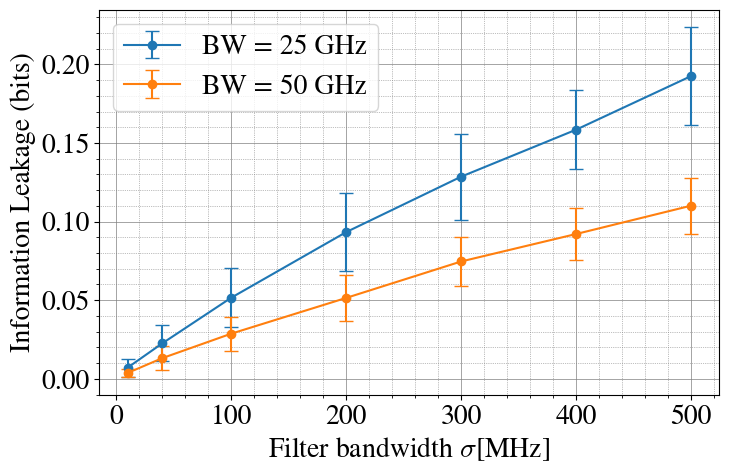

In [18]:
gams = cp.array([10e6,40e6,100e6,200e6,300e6,400e6,500e6]) # filter widths
BWS = [25e9, 50e9]                                         # Bandwidth of encoding
tend = 100e-9                                              # the time of the last vector
tend_justdata = 10e-9                                      # end of information
alpha = 1

IS, IS_ERR = [[],[]]

#start iterating
fig, ax1 = plt.subplots(figsize=(8, 5))

for BW in BWS:

    # Define the vectors
    ######## time domain
    tau =  0.44 / BW * np.sqrt(2)
    t_time_bin = 10 * tau / np.sqrt(2)
    N = int(np.round(tend_justdata / t_time_bin))
    tstep = tau / 4
    tstart = 0
    t = cp.arange(tstart, tend, tstep)
    Ntotal = len(t)

    ####### frequency domain
    fstart = -1/(2*tstep); fend = 1/(2*tstep); fstep = 1/(Ntotal*tstep)
    f = cp.linspace(fstart, fend, len(t))

    TS, TS_err = [[],[]]
    XIS, XIS_err = [[],[]]
    INFO_lEAKS, INFO_lEAKS_ERR = [[],[]]

    for gam in gams:

        Ts, xis, Info_leak = [[],[],[]]

        for runs in range(200):
            # Make vectors
            w_info = cp.random.uniform(-1, 1, N) + 1j*cp.random.uniform(-1, 1, N)
            x_info = cp.random.uniform(-1, 1, N) + 1j*cp.random.uniform(-1, 1, N)

            w,x = make_two_vec_gauss1(w_info,x_info,t,tau,t_time_bin)
            x = x/cp.sqrt(2)

            factor_w = cp.sqrt(cp.mean(cp.abs(w_info)**2))
            w = alpha * w / factor_w  # Normalize so that the mean of the power is 1

            # Step 1:
            u, u_tag = step_1(x, w)

            # Step 2:
            filtered_u, reflected_u = step_2(u, gam, f)

            # Step 3:
            w_tag = step_3(x, reflected_u, u_tag)

            # Calculate the metrics
            T = float(cp.sum(cp.abs(w_tag)**2) / cp.sum(cp.abs(w)**2))
            Ts.append(T)

            xi = float(cp.sum(cp.abs(w_tag-w)**2) / cp.sum(cp.abs(w)**2))
            xis.append(xi)

            Info_leak.append(calculate_S_AB(1, T, xi))

        TS.append(np.mean(Ts))
        TS_err.append(np.std(Ts))
        XIS.append(np.mean(xis))
        XIS_err.append(np.std(xis))
        INFO_lEAKS.append(np.mean(Info_leak))
        INFO_lEAKS_ERR.append(np.std(Info_leak))

        print(f'with gam = {gam*1e-6} MHz, T = {np.mean(Ts)} +- {np.std(Ts)}, xi = {np.mean(xis)} +- {np.std(xis)}')

    IS.append(INFO_lEAKS)
    IS_ERR.append(INFO_lEAKS_ERR)
    print('Ended with N = %d'%(N))

    ax1.errorbar(cp.asnumpy(gams*1e-6), cp.asnumpy(INFO_lEAKS), cp.asnumpy(INFO_lEAKS_ERR), fmt='o-',label='BW = %d GHz'%(BW*1e-9), capsize=5)
    ax1.set_xlabel("Filter bandwidth $\sigma$[MHz]")
    ax1.set_ylabel("Information Leakage (bits)")
    ax1.grid(True)
    ax1.minorticks_on()
    ax1.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
    ax1.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

plt.legend()


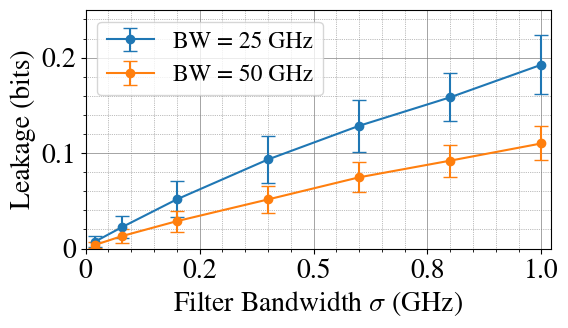

In [19]:
# Custom formatter for x-axis ticks
def custom_formatter(x, pos):
    if x == 0:
        return '0'  # No decimal point for zero
    else:
        return f'{x:.1f}'  # One decimal place for other values

if 0 :
  data = np.load('info_leaks13.npz')
  IS = data['IS']
  IS_ERR = data['IS_ERR']
  BWS = data['BWS']
  tend_justdata = data['tend_justdata']
  gams = data['gams']

fig,ax1 = plt.subplots(figsize = (6,3.1))
for info_leak, info_leak_err, BW in zip(IS,IS_ERR, BWS):
    ax1.errorbar(cp.asnumpy(gams*1e-9)*2, cp.asnumpy(info_leak), cp.asnumpy(info_leak_err), fmt='o-', label='BW = %d GHz'%(BW*1e-9), capsize=5)
    ax1.set_xlabel("Filter Bandwidth $\sigma$ (GHz)")
    ax1.set_ylabel("Leakage (bits)")
    ax1.grid(True)
    ax1.minorticks_on()
    ax1.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
    ax1.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
    ax1.set_xlim([0,1.02])
    ax1.set_ylim([0,0.25])
ax1.xaxis.set_major_formatter(plt.FuncFormatter(custom_formatter))
ax1.yaxis.set_major_formatter(plt.FuncFormatter(custom_formatter))
plt.legend()
plt.legend(loc = 'upper left', fontsize = 17)#, bbox_to_anchor=(0.0, 1.05))

if 0 :
  plt.savefig("info_leak5.svg", format="svg")   # SVG format
  np.savez('info_leaks1.npz', IS=IS,IS_ERR=IS_ERR, BWS=BWS,tend_justdata=tend_justdata,gams=gams)